## Burgers Equation - Modified
#### Parameter estimation for Burgers' Equation - Modified using Gaussian processes (Backward Euler scheme)


#### Problem Setup

$u_t + \nu u u_{x} = 0$

$u(x,t) = \frac{x}{1+t}$ => We'd expect $\nu = 1$

$u_0(x) := u(x,0) = x$

$x \in [0, 1], t \in \{0, \tau \}$

Using the backward Euler scheme, the equation can be re-written as:

$\frac{u_n - u_{n-1}}{\tau} + \nu u_n \frac{d}{dx}u_n  = 0$

and setting $u_n = \mu_{n-1}$ to deal with the non-linearity:

$u_n + \tau \nu \mu_{n-1} \frac{d}{dx}u_n = u_{n-1}$


Consider $u_n$ to be a Gaussian process.

$u_n \sim \mathcal{GP}(0, k_{uu}(x_i, x_j, \theta))$

And the linear operator:

$\mathcal{L}_x^\nu = \cdot + \tau \nu \mu_{n-1} \frac{d}{dx}\cdot$

so that

$\mathcal{L}_x^\nu u_n = u_{n-1}$

Problem at hand: estimate $\nu$ (should be $\nu = 1$ in the end).

For the sake of simplicity, take $u := u_n$ and $f := u_{n-1}$.


#### step 1: Simulate data

Take data points at $t = 0$ for $(u_{n-1})$ and $t = \tau$ for $(u_n)$, where $\tau$ is the time step.

In [1]:
import numpy as np
import sympy as sp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
import time

In [2]:
tau = 0.001
def get_simulated_data(tau, n=20):
    x = np.random.rand(n)
    y_u = x/(1+tau)
    y_f = x
    return (x, y_u, y_f)

(x, y_u, y_f) = get_simulated_data(tau)

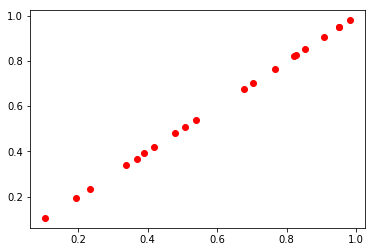

In [3]:
plt.plot(x, y_u, 'ro')
plt.show()

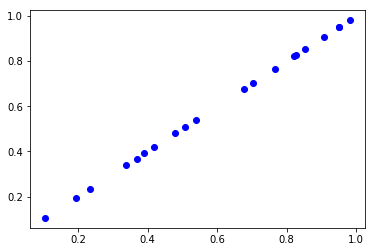

In [4]:
plt.plot(x, y_f, 'bo')
plt.show()

#### Step 2:Evaluate kernels

$k_{nn}(x_i, x_j; \theta) = \theta exp(-\frac{1}{2l}(x_i-x_j)^2)$

In [5]:
x_i, x_j, theta, l, nu = sp.symbols('x_i x_j theta l nu')
mu = np.mean(y_f)
kuu_sym = theta*sp.exp(-1/(2*l)*((x_i - x_j)**2))
kuu_fn = sp.lambdify((x_i, x_j, theta, l), kuu_sym, "numpy")
def kuu(x, theta, l):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kuu_fn(x[i], x[j], theta, l)
    return k

$k_{ff}(x_i,x_j;\theta,\phi) \\
= \mathcal{L}_{x_i}^\nu \mathcal{L}_{x_j}^\nu k_{uu}(x_i, x_j; \theta) \\
= k_{uu} + \tau \nu \mu_{n-1} \frac{d}{dx_i}k_{uu} + \tau \nu \mu_{n-1} \frac{d}{dx_j}k_{uu} + \tau^2 \nu^2 \mu_{n-1}^2 \frac{d^2}{d x_i x_j} k_{uu}$

In [6]:
kff_sym = kuu_sym \
        + tau*nu*mu*(sp.diff(kuu_sym, x_i) + sp.diff(kuu_sym, x_j)) \
        + tau**2*nu**2*mu**2*sp.diff(kuu_sym, x_i, x_j)
kff_fn = sp.lambdify((x_i, x_j, theta, l, nu), kff_sym, "numpy")
def kff(x, theta, l, nu):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kff_fn(x[i], x[j], theta, l, nu)
    return k

$k_{fu}(x_i,x_j;\theta,\phi) \\
= \mathcal{L}_{x_i}^\nu k_{uu}(x_i, x_j; \theta) \\
= k_{uu} + \tau \mu_{n-1} \nu \frac{d}{dx_i}k_{uu} $

In [7]:
kfu_sym = kuu_sym + tau*mu*nu*sp.diff(kuu_sym, x_i)
kfu_fn = sp.lambdify((x_i, x_j, theta, l, nu), kfu_sym, "numpy")
def kfu(x, theta, l, nu):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kfu_fn(x[i], x[j], theta, l, nu)
    return k

In [8]:
def kuf(x, theta, l, nu):
    return kfu(x,theta, l, nu).T

#### Step 3: Compute NLML

In [9]:
def nlml(params, x, y1, y2, s):
    theta_exp = np.exp(params[0]) 
    l_exp = np.exp(params[1])
    K = np.block([
        [kuu(x, theta_exp, l_exp) + s*np.identity(x.size), kuf(x, theta_exp, l_exp, params[2])],
        [kfu(x, theta_exp, l_exp, params[2]), kff(x, theta_exp, l_exp, params[2]) + s*np.identity(x.size)]
    ])
    y = np.concatenate((y1, y2))
    val = 0.5*(np.log(abs(np.linalg.det(K))) + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

#### Step 4: Optimise hyperparameters

In [10]:
m = minimize(nlml, np.random.rand(3), args=(x, y_u, y_f, 1e-7), method="Nelder-Mead", options = {'maxiter' : 1000})

In [11]:
m.x[2]

0.9994300669651587

In [12]:
m

 final_simplex: (array([[6.72217068, 7.81870533, 0.99943007],
       [6.72217757, 7.81870686, 0.99942905],
       [6.72224191, 7.81878793, 0.9994286 ],
       [6.72221172, 7.81875754, 0.99942915]]), array([-293.59378882, -293.59377864, -293.59377797, -293.59377179]))
           fun: -293.59378881947436
       message: 'Optimization terminated successfully.'
          nfev: 225
           nit: 116
        status: 0
       success: True
             x: array([6.72217068, 7.81870533, 0.99943007])

#### Analysis w.r.t. the number of data points (up to 25):

In this section we want to analyze the error of our algorithm using two different ways and its time complexity.

In [13]:
res = np.zeros((5,25))
timing = np.zeros((5,25))
warnings.filterwarnings("ignore")
for k in range(5):
    for n in range(25):
        start_time = time.time()
        (x, y_u, y_f) = get_simulated_data(tau, n)
        m = minimize(nlml, np.random.rand(3), args=(x, y_u, y_f, 1e-7), method="Nelder-Mead")
        res[k][n] = m.x[2]
        timing[k][n] = time.time() - start_time

###### Plotting the error in our estimate for $\nu$ (Error = $| \nu_{estimate} - \nu_{true} |$):

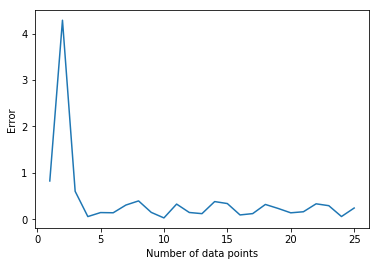

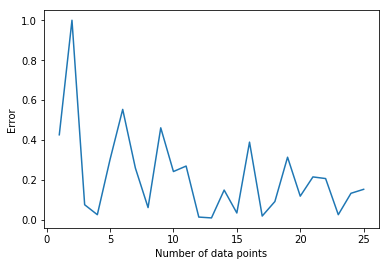

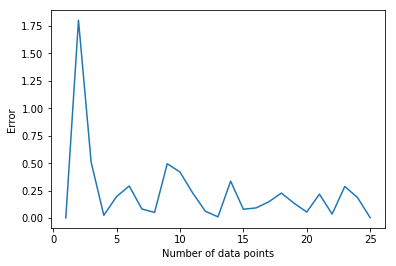

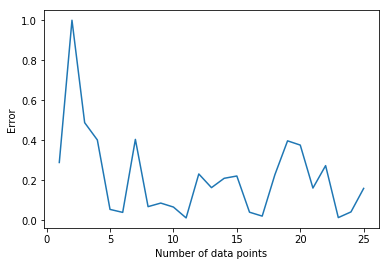

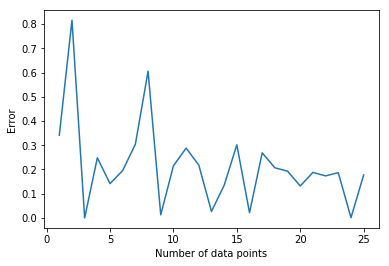

In [14]:
lin = np.linspace(1, res.shape[1], res.shape[1])
ones = np.ones(res.shape[1])

for i in range(res.shape[0]):
    plt.plot(lin, np.abs(res[i,:] - ones))
    plt.ylabel('Error')
    plt.xlabel('Number of data points')
    plt.show()

All in one plot:

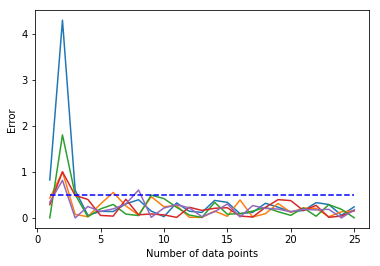

In [28]:
lin = np.linspace(1, res.shape[1], res.shape[1])
ones = np.ones(res.shape[1])

for i in range(res.shape[0]):
    plt.plot(lin, np.abs(res[i,:] - ones))
    plt.ylabel('Error')
    plt.xlabel('Number of data points')

est = np.repeat(0.5, len(lin))
plt.plot(lin, est, color='blue', linestyle='dashed')
plt.show()

We see that for n sufficiently large (in this case $n \geq 8$), we can assume the error to be bounded by 0.5. <br>
It seems to be difficult to (even roughly) describe the limiting behavior of the error w.r.t. the number of data points

###### Plotting the error between the solution and the approximative solution:

Another approach of plotting the error is by calculating the difference between the approximative solution and the true solution. <br>
That is: Let $\tilde{\nu}$ be the parameter, resulting from our algorithm. Set $\Omega := ([0,1] \times {0}) \cup ([0,1] \times {\tau})$
Then we can calculate the solution of the PDE 

\begin{align}
    \frac{d}{dt}\tilde{u}(x,t) + \tilde{\nu}\tilde{u}(x,t)\frac{d}{dx}\tilde{u}(x,t) = 0.  
\end{align}

and set the error to $\lVert \tilde{u}(x,t) - u(x,t) \rVert_{\Omega}$. The norm can be chosen freely. <br>
In our case, finding the solution to a given $\tilde{\nu}$ is very simple. It is given by $\tilde{u}(x,t) = \frac{1}{\tilde \nu}u(x,t) = \frac{1}{\tilde \nu}\frac{x}{1+t}$. <br>
We thus get:

\begin{align}
\lVert \tilde{u}(x,t) - u(x,t) \rVert_{\Omega} = \lVert \frac{1}{\tilde{\nu}} u(x,t) - u(x,t) \rVert_{\Omega} = \vert \frac{1}{\tilde{\nu}} - 1 \vert \lVert u(x,t) \rVert_{\Omega} \propto \vert \frac{1}{\tilde{\nu}}-1 \vert
\end{align}

The plot of the error looks as follows:

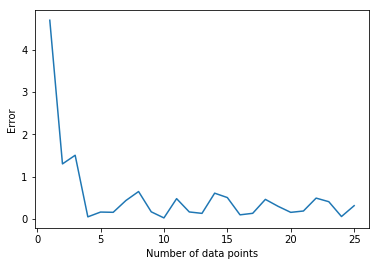

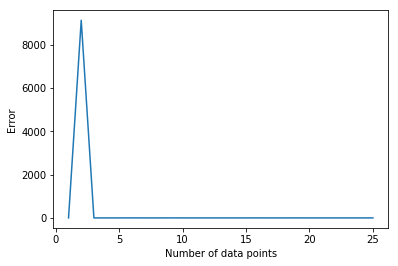

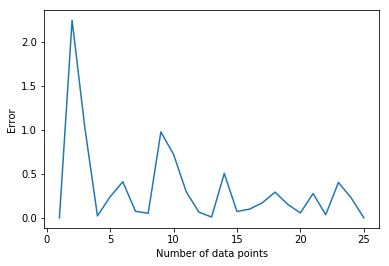

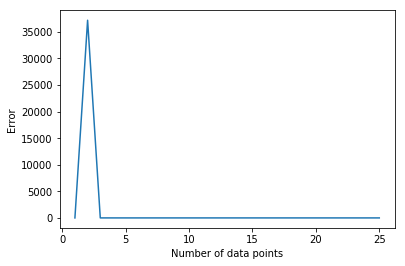

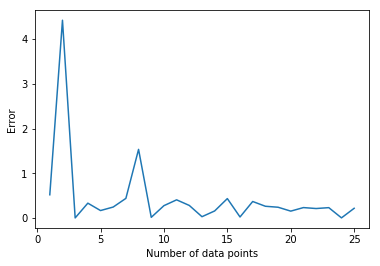

In [40]:
lin = np.linspace(1, res.shape[1], res.shape[1])
ones = np.ones(res.shape[1])

for i in range(res.shape[0]):
    plt.plot(lin, np.abs(np.divide(ones, res[i,:]) - ones))
    plt.ylabel('Error')
    plt.xlabel('Number of data points')
    plt.show()

###### Plotting the execution time:

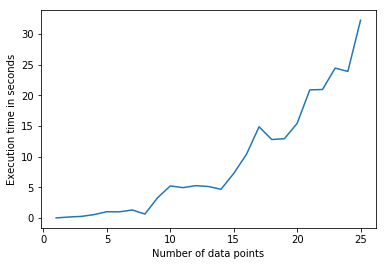

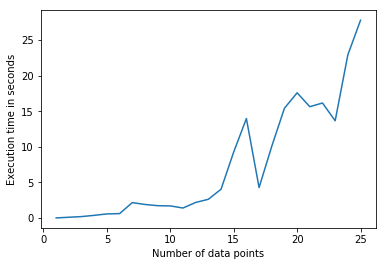

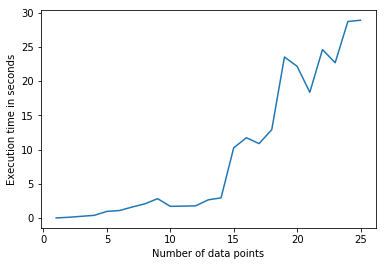

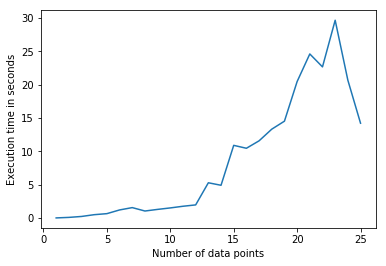

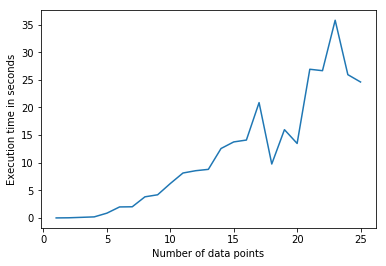

In [19]:
lin = np.linspace(1, timing.shape[1], timing.shape[1])

for i in range(timing.shape[0]):
    plt.plot(lin, timing[i,:])
    plt.ylabel('Execution time in seconds')
    plt.xlabel('Number of data points')
    plt.show()

All in one plot:

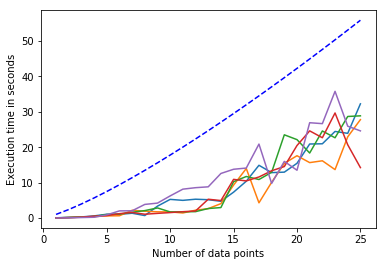

In [33]:
lin = np.linspace(1, timing.shape[1], timing.shape[1])

for i in range(timing.shape[0]):
    plt.plot(lin, timing[i,:])
    plt.ylabel('Execution time in seconds')
    plt.xlabel('Number of data points')

est = lin**(1.25)
plt.plot(lin, est, color='blue', linestyle='dashed')
plt.show()

Curiously, the time complexity seems to be around $\mathcal{O}(n^{5/4})$ (blue-dashed line). <br>
Assuming an equal amount of function evaluations in the Nelder-Mead algorithm for different values of n,
we would expect a time complexity of $\mathcal{O}(n^3)$, due to the computation of the inverse of an $n\times n$-matrix in every evaluation of $\textit{nlml}$.